<a href="https://colab.research.google.com/github/DorisCCLin/Kaggle-Spaceship-Titanic/blob/main/Spaceship_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spaceship Titanic

In [1]:
## Import packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt

In [29]:
# Path to training CSV that was uploaded in the session
DATA_PATH = "train.csv"
print('Expecting train CSV at:', DATA_PATH)
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found at {DATA_PATH} — upload it or change DATA_PATH")

df = pd.read_csv(DATA_PATH)
print('Loaded dataset shape:', df.shape)

Expecting train CSV at: train.csv
Loaded dataset shape: (8693, 14)


In [30]:
# Check overall data
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [31]:
# Check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## Handle Missing Data

In [32]:
# See all missing data
df.isnull().sum().sort_values(ascending=False)

,0
CryoSleep,217
ShoppingMall,208
VIP,203
HomePlanet,201
Name,200
Cabin,199
VRDeck,188
Spa,183
FoodCourt,183
Destination,182


In [33]:
# understand numerical column data
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [34]:
# understand categorical column data
df.describe(include=['O'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,9280_02,Earth,False,G/734/S,TRAPPIST-1e,False,Ankalik Nateansive
freq,1,4602,5439,8,5915,8291,2


In [35]:
## handle missing values, most miss values are just small percentage of data, we can use mean or mode to imputate the data

# handle "FoodCourt", "ShoppingMall", "Spa", "VRDeck" missing value with 0 as almost over 50% passengers doesn't have any value in those columns.
df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]] = df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].fillna(0)

# handle "Age" columns with mean value
df["Age"] = df["Age"].fillna(df["Age"].mean())

# handle "HomePlanet", "CryoSleep", "Destination", "VIP" with mode value
for col in ["HomePlanet", "CryoSleep", "Destination", "VIP"]:
    df[col] = df[col].fillna(df[col].mode()[0])


/tmp/ipython-input-2991339688.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


In [44]:
## Handle "Cabin" column

# Fill NaN value with string format 'Unknown/0/Unknown' to match the value format
df["Cabin"] = df['Cabin'].fillna('Unknown/0/Unknown').astype(str)

# Split the data string value
parts = df["Cabin"].str.split('/', expand=True)

# Seperate "Cabin" to "Deck", "CabinNum" and "Side"
df['Deck'] = parts[0]
df['CabinNum'] = pd.to_numeric(parts[1], errors='coerce')
df['Side'] = parts[2]

# Drop the original "Cabin" column
df.drop('Cabin', axis=1, inplace=True)

# check null data again
df.isnull().sum().sort_values(ascending=False)



,0
Name,200
PassengerId,0
CryoSleep,0
HomePlanet,0
Age,0
VIP,0
RoomService,0
Destination,0
FoodCourt,0
ShoppingMall,0


In [45]:
# Drop "Name" and "PassengerId" columns
df.drop(['Name', 'PassengerId'], axis=1, inplace=True)

In [ ]:
# Convert bool c

## Visualizing Data

### Univariate Analysis

In [64]:
numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object','bool']).columns
target_col = 'Transported'

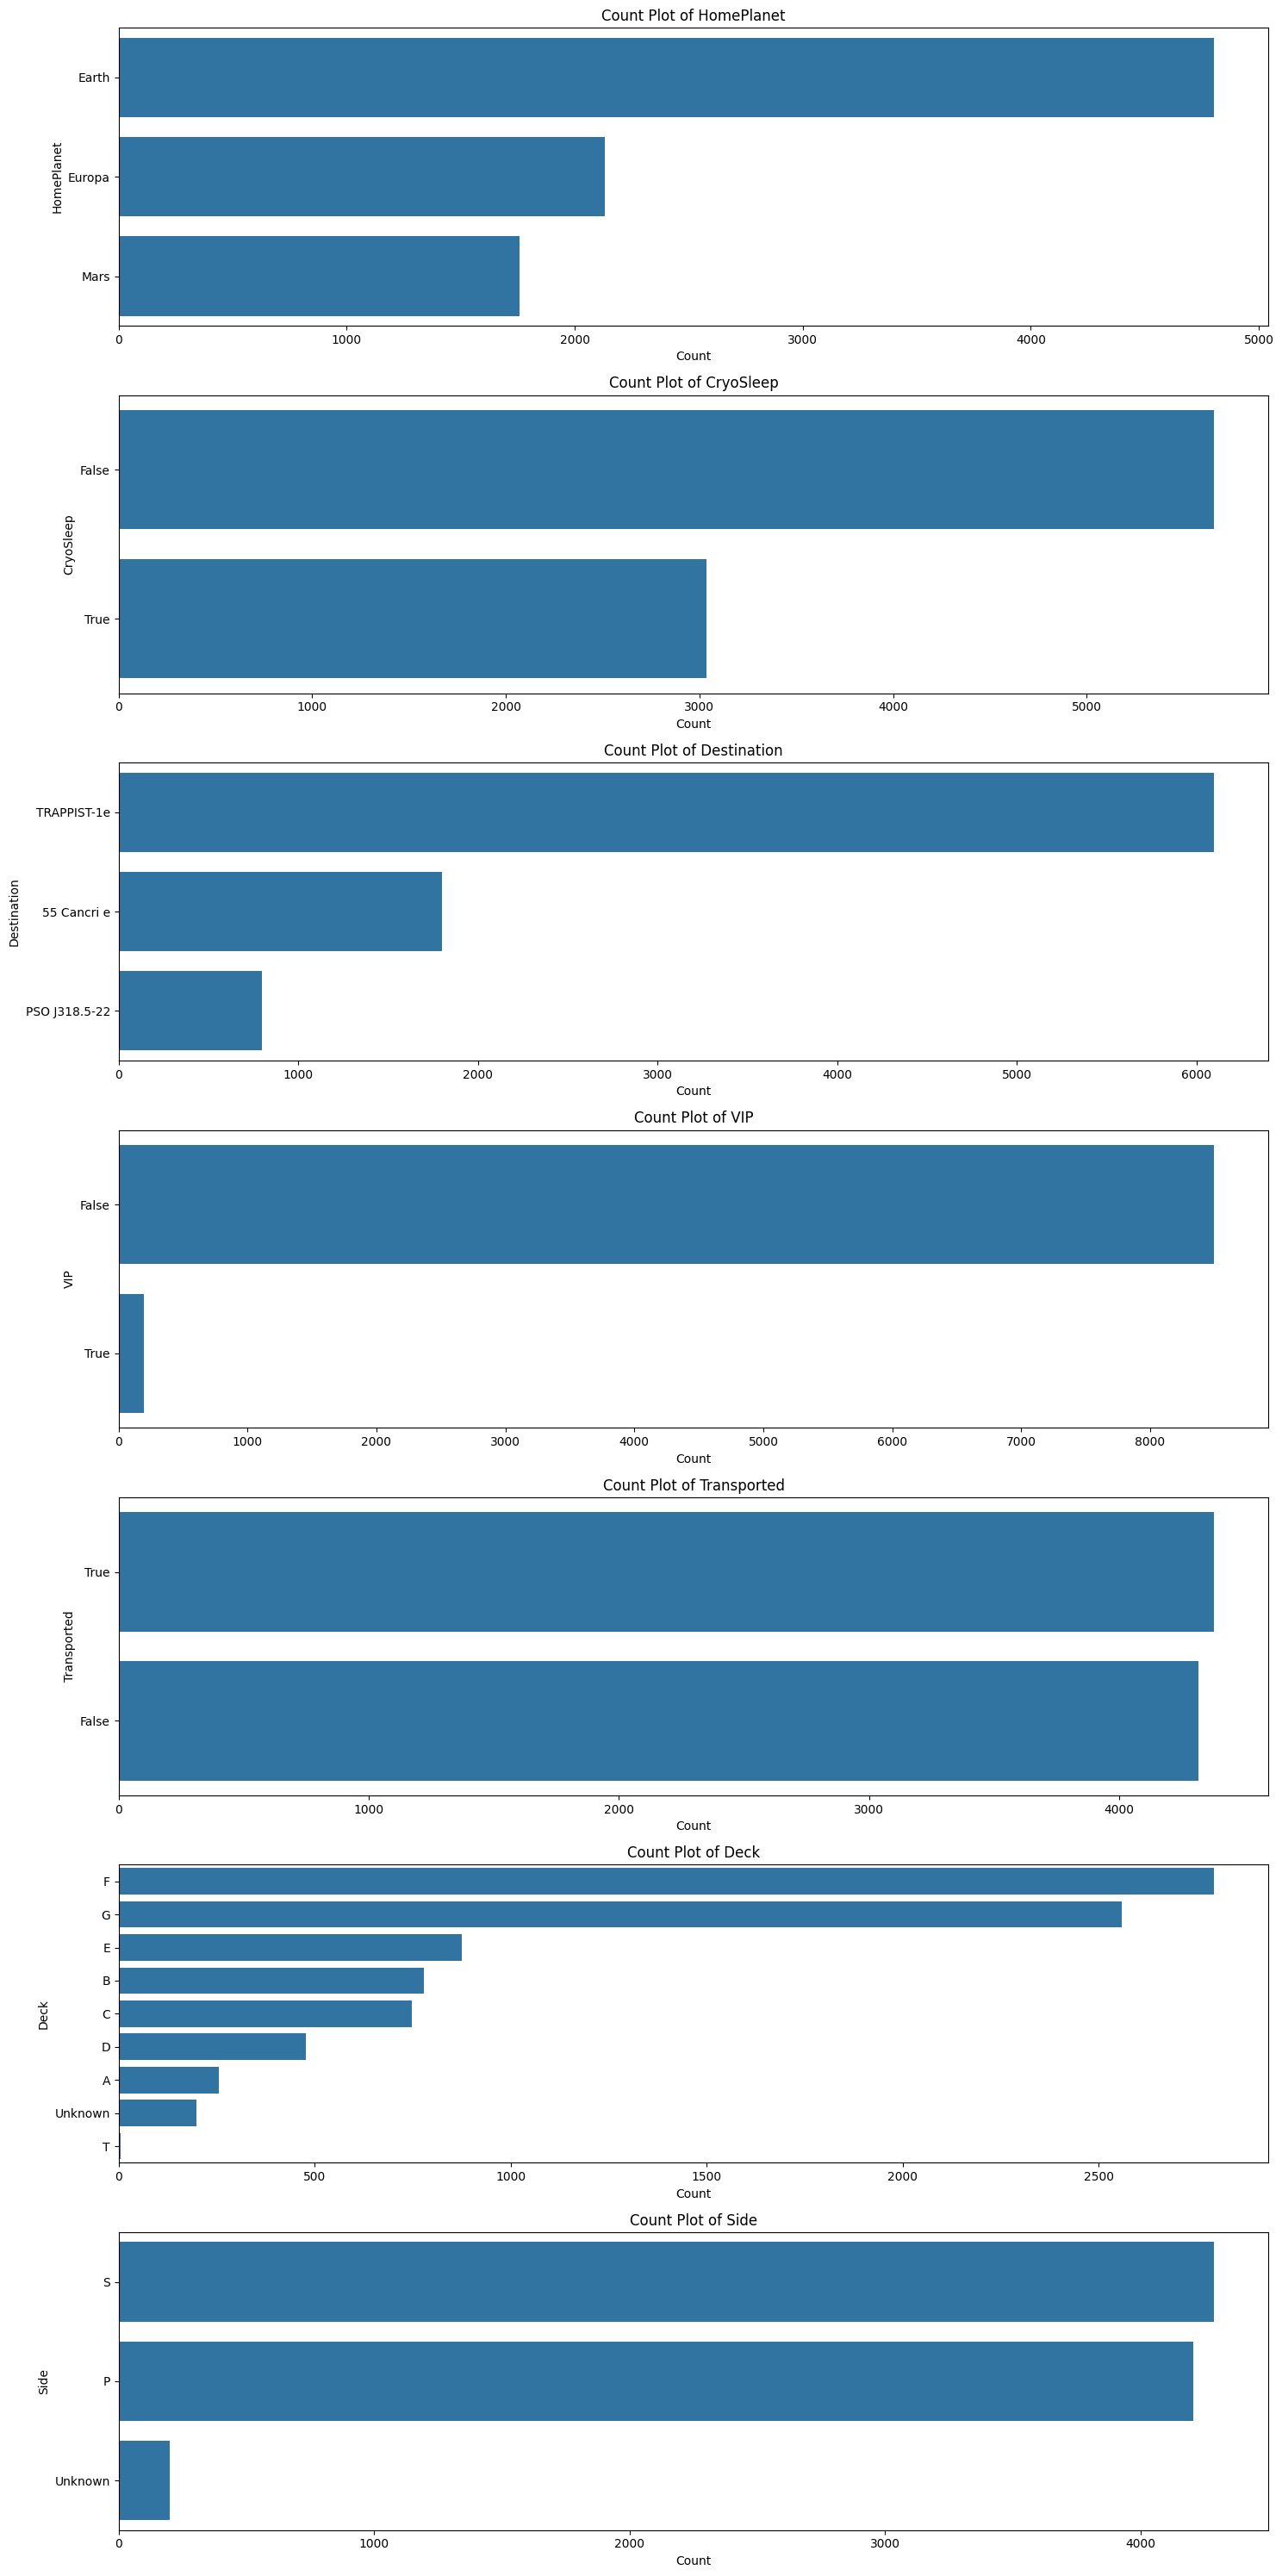

In [67]:
## Vistualizing the categorical features
fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(15, 30))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(y=df[col], ax=axes[i], order=df[col].value_counts().index)
    axes[i].set_title(f'Count Plot of {col}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

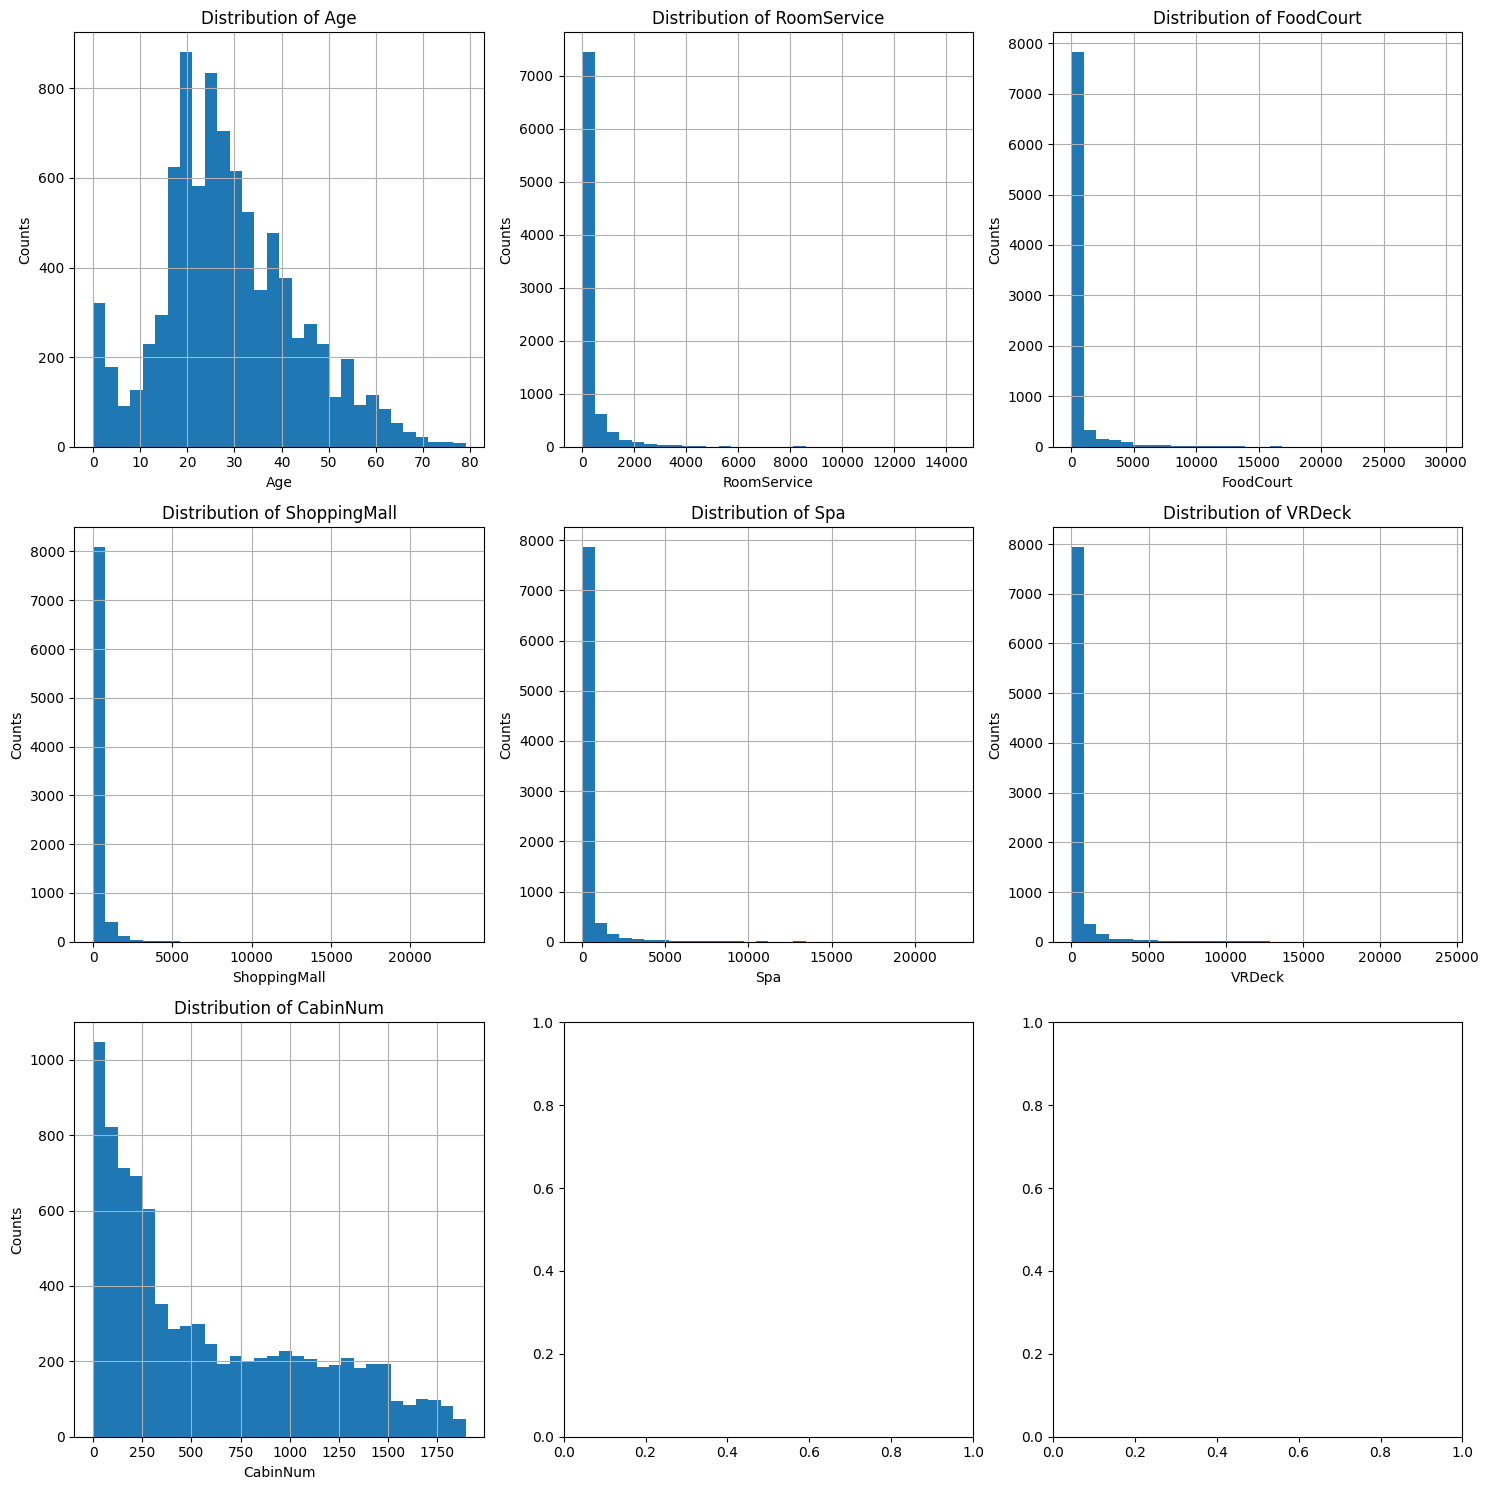

In [54]:
## Visualiziing numerical Features distribution

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    if col in df.columns:
        df[col].hist(ax=axes[i], bins=30)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Counts')
    else:
        axes[i].set_title(f'{col} not in DataFrame')
        axes[i].axis('off') # Hide the subplot if column not found

plt.tight_layout()
plt.show()

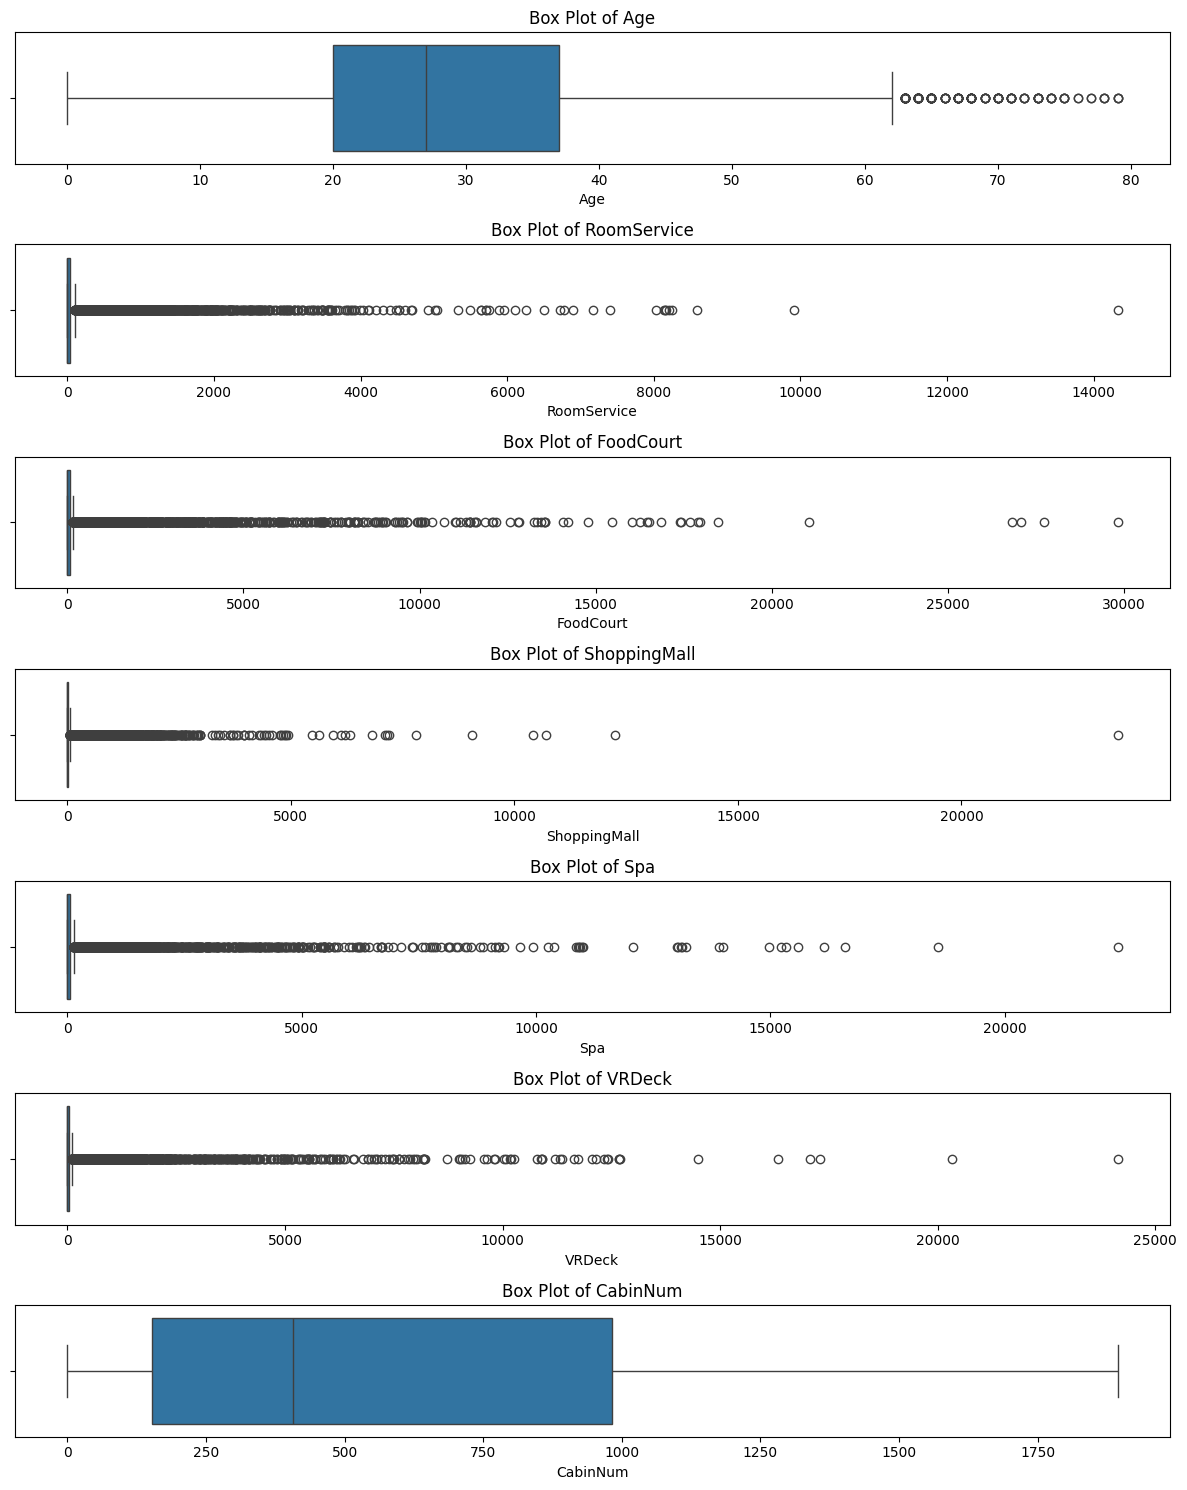

In [52]:
## Visualiziing numerical Features using Box Plots
fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(12, 15))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

<Axes: xlabel='Transported'>

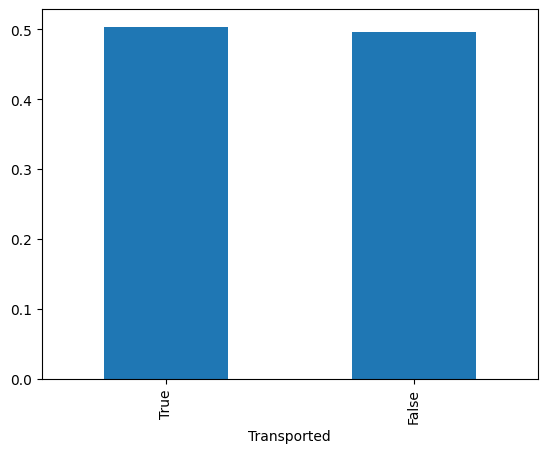

In [53]:
# Visualize target column distribution
plt.figure()
df[target_col].value_counts(normalize=True).plot(kind='bar')

- Target value distribution is quite balanced.

### Bivariate Analysis

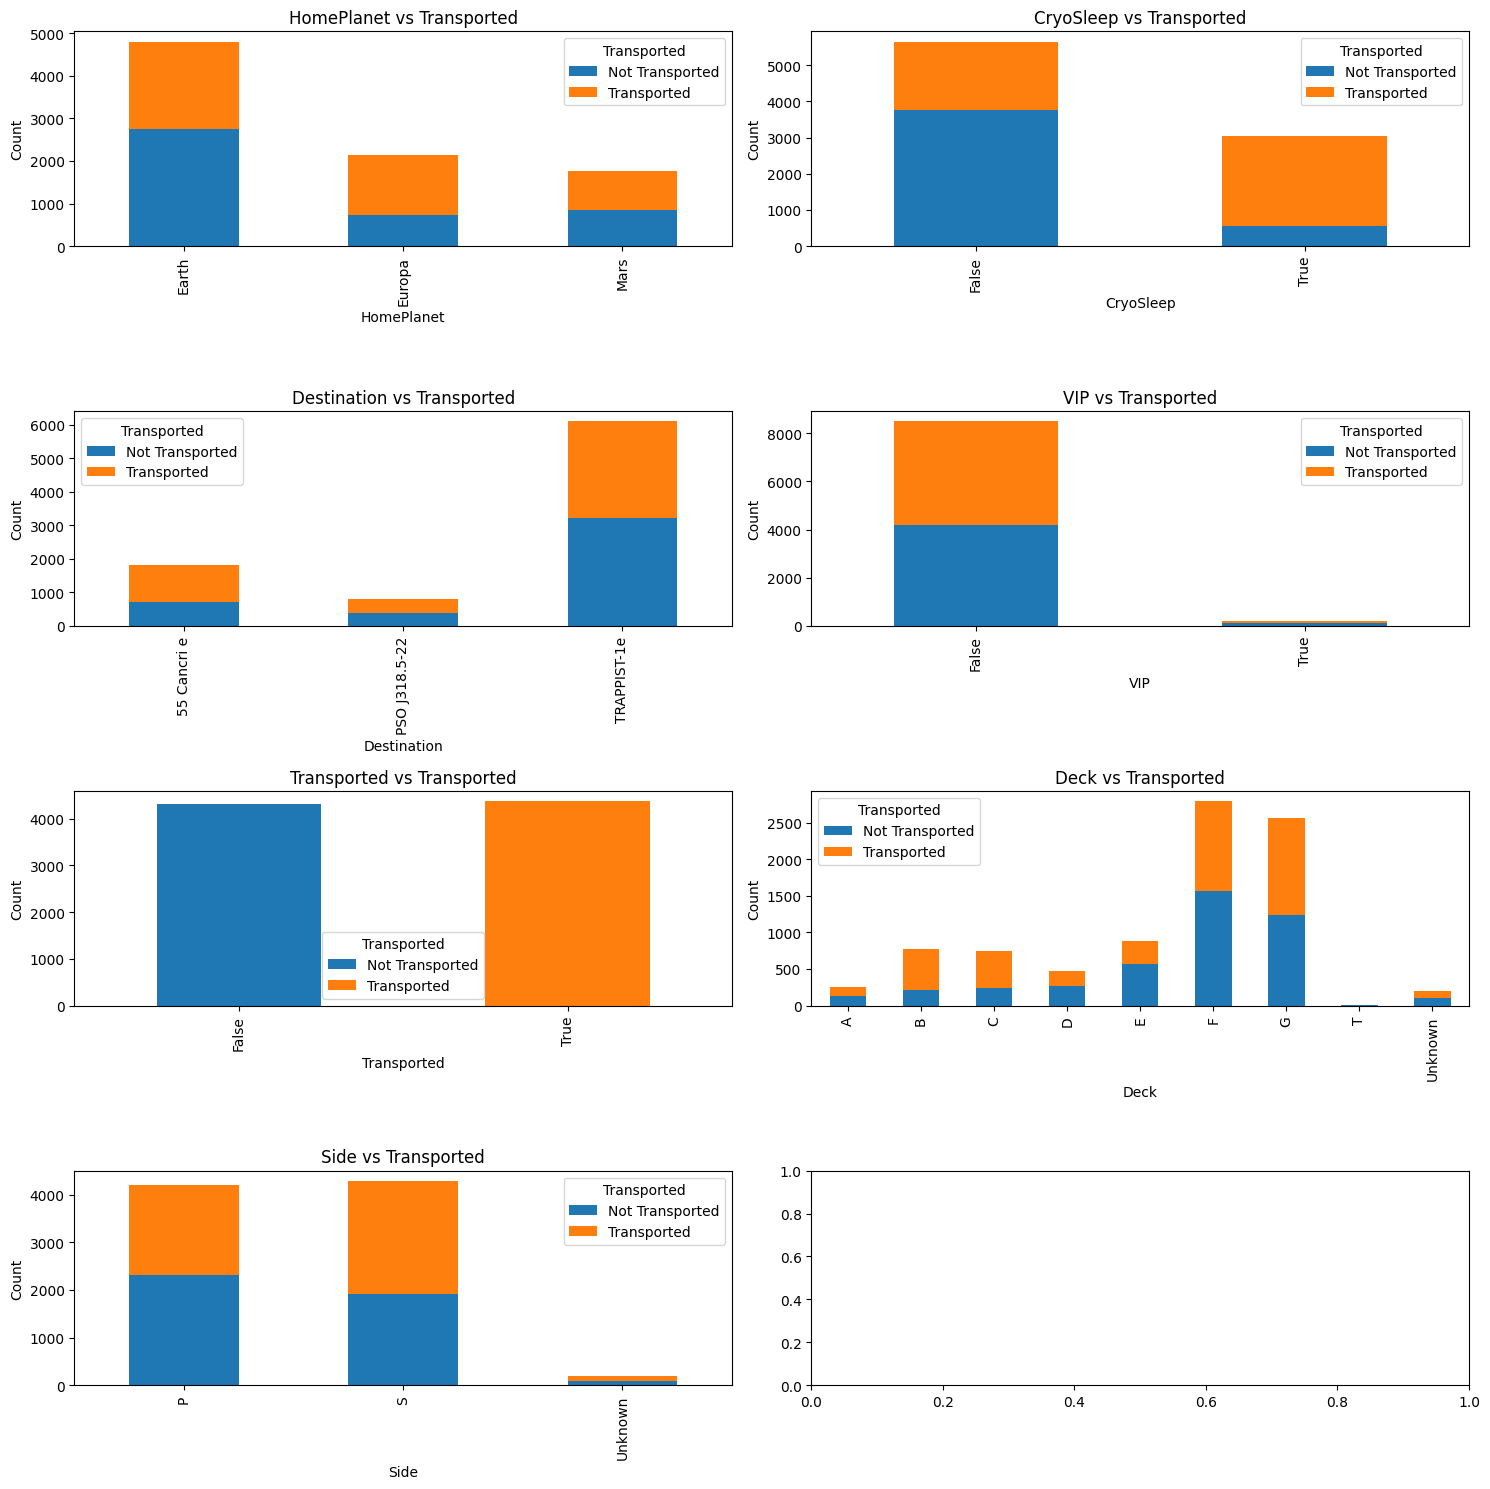

In [69]:
# Visualize relationship between categorical features and target
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if col in df.columns and target_col in df.columns:
        # Create a cross-tabulation of the feature and target
        ct = pd.crosstab(df[col], df[target_col])
        ct.plot(kind='bar', stacked=True, ax=axes[i])
        axes[i].set_title(f'{col} vs {target_col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        axes[i].legend(title=target_col, labels=['Not Transported', 'Transported'])
    else:
        axes[i].set_title(f'{col} or {target_col} not in DataFrame')
        axes[i].axis('off') # Hide the subplot if column not found

plt.tight_layout()
plt.show()

In [ ]:
# Visualize relationship between numerical features and target

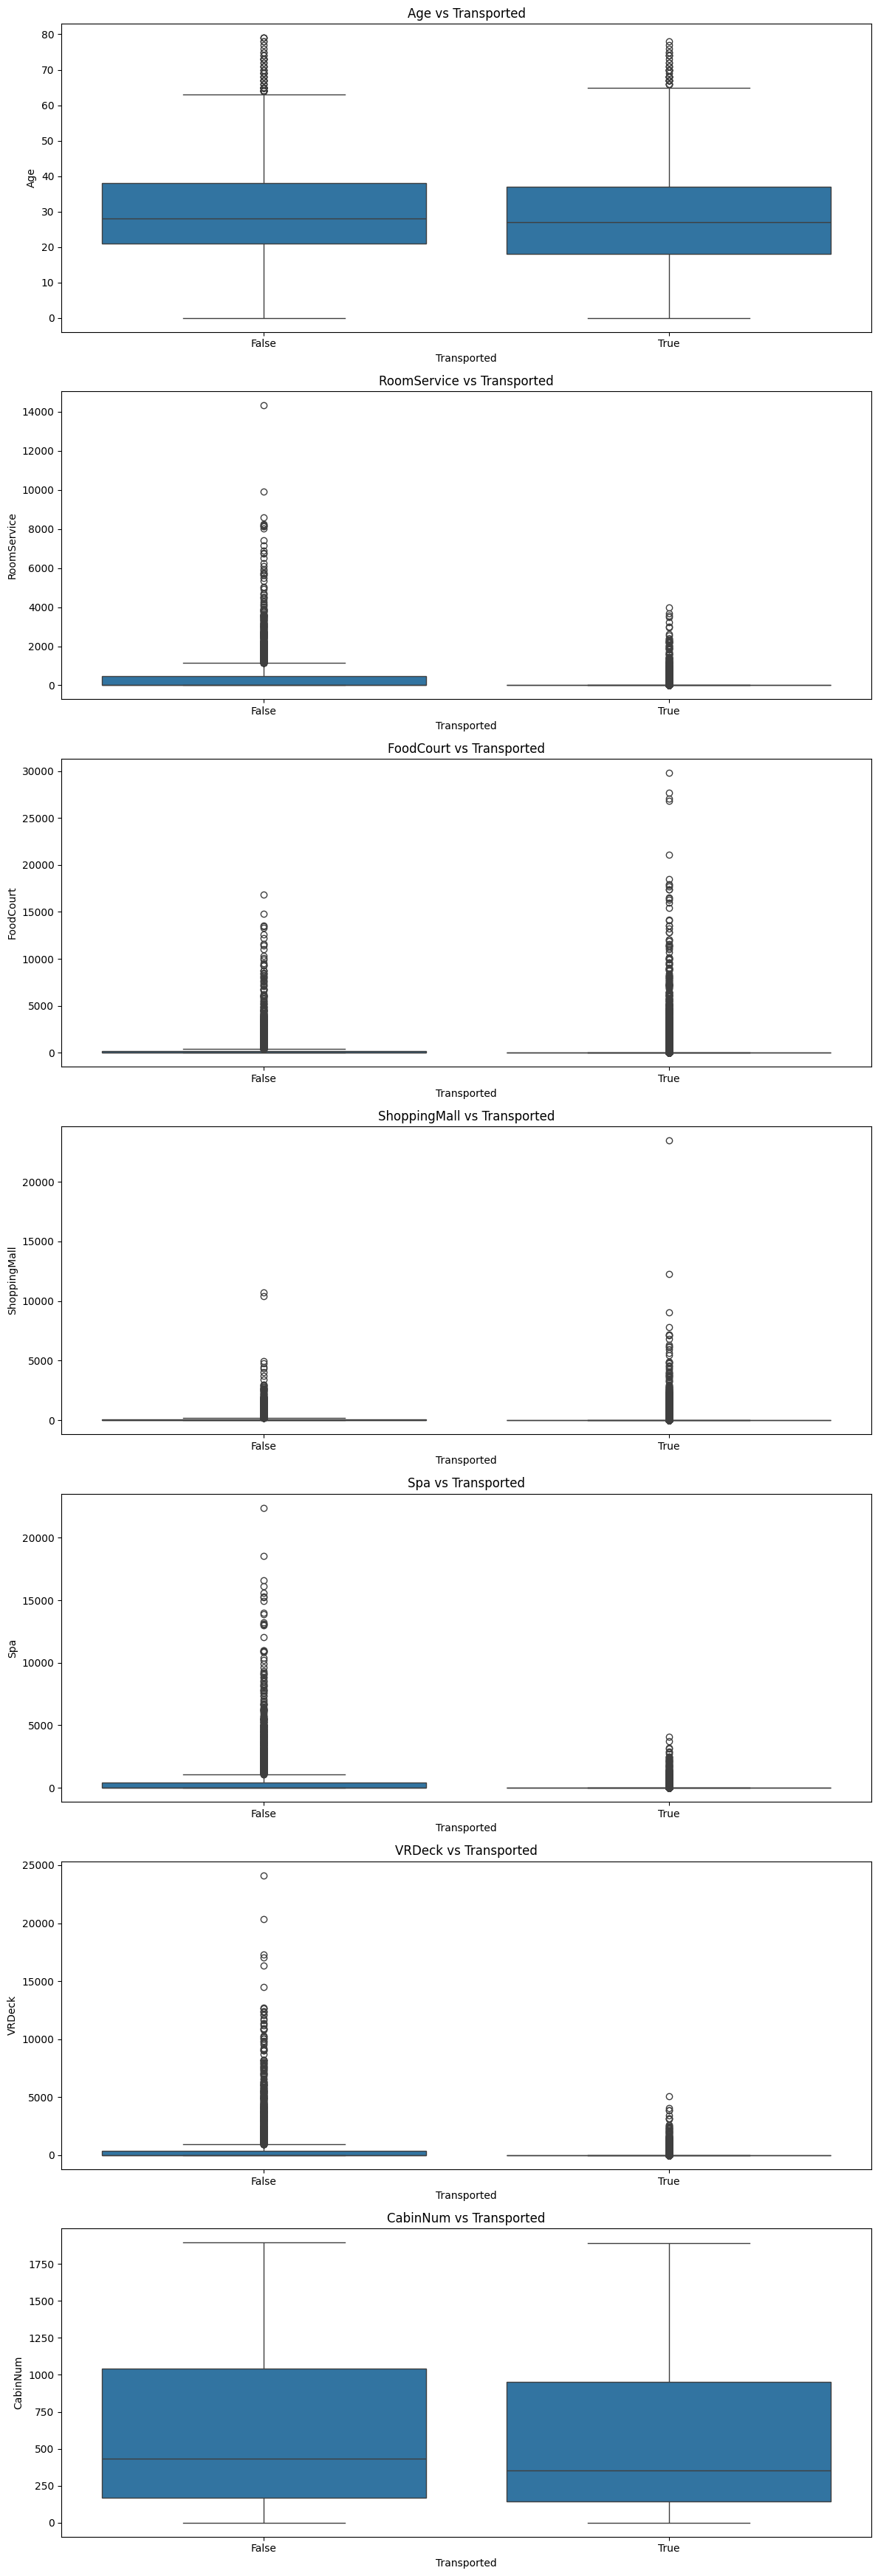

In [71]:
fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(12, 5 * len(numerical_cols)))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    if col != target_col: # Exclude target_col if it somehow ends up in numerical_cols
        sns.boxplot(x=df[target_col], y=df[col], ax=axes[i])
        axes[i].set_title(f'{col} vs {target_col}')
        axes[i].set_xlabel(target_col)
        axes[i].set_ylabel(col)
    else:
        axes[i].set_title(f'{col} is the target column')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

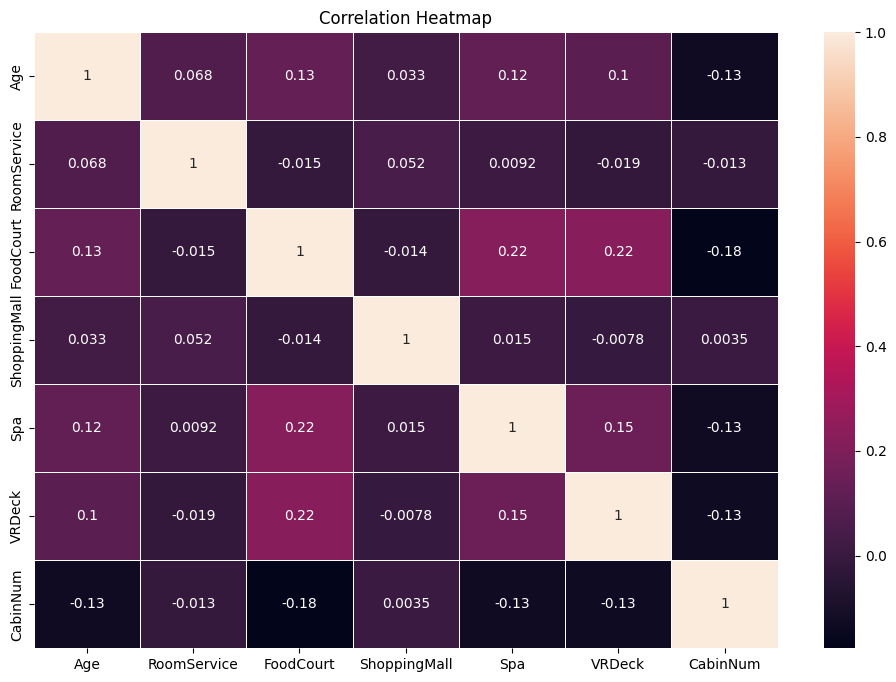

In [73]:
# Plotting a heat map to show correlation matrix
# Calculate correlation matrix only for the numerical columns of the DataFrame
cor_matrix = df[numerical_cols].corr()
plt.figure(figsize=(12, 8))  # Set the figure size
sns.heatmap(cor_matrix, annot=True, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## Pre-processing data before building the model

In [74]:
# Import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

# create encoder object
encoder = OneHotEncoder(sparse_output=False, drop='first')

# apply all the categorical variables
for col in df.select_dtypes(include=['object', 'bool']):
    df[col] = encoder.fit_transform(df[[col]])

print(df.shape)
df.head()


(8693, 14)


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNum,Side
0,1.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0
1,0.0,0.0,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,0.0,0,1.0
2,1.0,0.0,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0.0,0,1.0
3,1.0,0.0,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0.0,0,1.0
4,0.0,0.0,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,0.0,1,1.0


### train-validation split

In [76]:
# Set features and target
X = df.drop('Transported', axis=1)
y = df['Transported']

- no need for SMOTE as the data is balanced.

In [79]:
# Splitting our dataset between training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [80]:
## Check the samples
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (6954, 13)
Shape of X_test: (1739, 13)
Shape of y_train: (6954,)
Shape of y_test: (1739,)


### scaling

In [81]:
from sklearn.preprocessing import MinMaxScaler
# Write code for MinMax Scaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Building Model

In [82]:
## Build vinalla Logistic Regression model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report

# Build the model
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

# Check its evaluation metrics
y_pred = logistic_regression_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

# Plot the classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.765382403680276
Recall: 0.6968641114982579
Precision: 0.8032128514056225
              precision    recall  f1-score   support

         0.0       0.74      0.83      0.78       878
         1.0       0.80      0.70      0.75       861

    accuracy                           0.77      1739
   macro avg       0.77      0.76      0.76      1739
weighted avg       0.77      0.77      0.76      1739



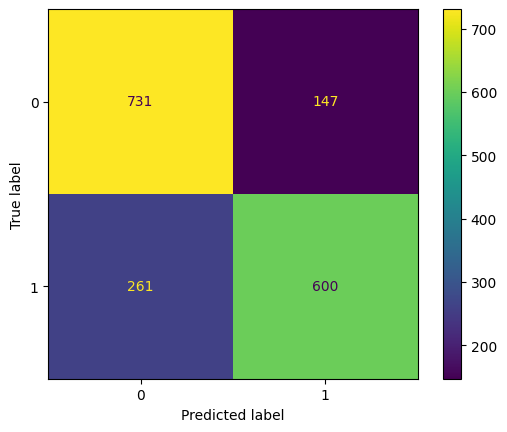

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

In [84]:
## Check if the model is overfitting
# Predict on the training set
y_train_pred = logistic_regression_model.predict(X_train)

# Calculate accuracy on the training set
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f'Accuracy on training set: {accuracy_train:.4f}')

# Accuracy on the test set (already calculated)
print(f'Accuracy on test set: {accuracy:.4f}')

Accuracy on training set: 0.7642
Accuracy on test set: 0.7654


In [86]:
## find the optimal threshold for the logistic model and improve AUC

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

# Predict probabilities for the test set (to calculate AUC and ROC curve)
y_proba = logistic_regression_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and find the optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Optimal threshold: the one that maximizes the difference between true positive rate and false positive rate
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold (based on TPR-FPR): {optimal_threshold:.4f}")

# Make predictions using the optimal threshold
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

# Calculate Precision, Recall, and F1 Score with the optimal threshold
precision_optimal = precision_score(y_test, y_pred_optimal)
recall_optimal = recall_score(y_test, y_pred_optimal)
f1_optimal = f1_score(y_test, y_pred_optimal)

# Calculate AUC (Area Under the ROC Curve)
roc_auc = roc_auc_score(y_test, y_proba)

# Print the evaluation metrics
print(f"Precision with Optimal Threshold: {precision_optimal:.4f}")
print(f"Recall with Optimal Threshold: {recall_optimal:.4f}")
print(f"F1 Score with Optimal Threshold: {f1_optimal:.4f}")
print(f"AUC: {roc_auc:.4f}")

Optimal Threshold (based on TPR-FPR): 0.4394
Precision with Optimal Threshold: 0.7825
Recall with Optimal Threshold: 0.7561
F1 Score with Optimal Threshold: 0.7690
AUC: 0.8528


### Now try tree-based models

In [85]:
## Build a vanilla Dicision Tree Classifier

# Import the required libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Initialize the Decision Tree Classifier
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data
decision_tree_model.fit(X_train, y_train)

# Predict on the test set
y_pred = decision_tree_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 0.7303
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.72      0.73       878
         1.0       0.72      0.74      0.73       861

    accuracy                           0.73      1739
   macro avg       0.73      0.73      0.73      1739
weighted avg       0.73      0.73      0.73      1739



In [87]:
## Check if the model is overfitting
# Predict on the training set
y_train_pred = decision_tree_model.predict(X_train)

# Calculate accuracy on the training set
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f'Accuracy on training set: {accuracy_train:.4f}')

# Accuracy on the test set (already calculated)
print(f'Accuracy on test set: {accuracy:.4f}')

Accuracy on training set: 0.9983
Accuracy on test set: 0.7303


- overfitting!

Let's use hyperparameter tuning to optimize the model and fix overfitting issue

In [88]:
## Build a vanilla Random Forest Classifier

# Import the required libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize the Decision Tree Classifier
random_forest_model = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
random_forest_model.fit(X_train, y_train)

# Predict on the test set
y_pred = random_forest_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.7959
Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.82      0.80       878
         1.0       0.81      0.77      0.79       861

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



In [89]:
## Build a basic XGB model

# Import the required libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=1234)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculate Precision, Recall, and F1 Score
accuracy_score_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

# Print the evaluation metrics
print("XGBoost Metrics:")
print(f"accuracy: {accuracy_score_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")

XGBoost Metrics:
accuracy: 0.8074
Precision: 0.7871
Recall: 0.8374
F1 Score: 0.8115


In [90]:
## Check if the model is overfitting
# Make predictions on the training set
y_pred_xgb_train = xgb_model.predict(X_train)

# Calculate Accuracy Score for the training set
accuracy_xgb_train = accuracy_score(y_train, y_pred_xgb_train)
print(f'Accuracy on training set: {accuracy_xgb_train:.4f}')

# Accuracy on the test set (already calculated)
print(f'Accuracy on test set: {accuracy_score_xgb:.4f}')

Accuracy on training set: 0.9019
Accuracy on test set: 0.8074


In [91]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1],
    'reg_lambda': [0, 0.001, 0.005, 0.01, 0.05, 0.1]
}

# Initialize XGBClassifier
xgboost_tuned_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=1234)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgboost_tuned_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='accuracy',
    cv=5,       # 5-fold cross-validation
    verbose=1,  # Verbosity level
    random_state=1234,
    n_jobs=-1   # Use all available CPU cores
)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best accuracy found: {random_search.best_score_:.4f}")

# Get the best model
best_xgb_model = random_search.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'subsample': 0.9, 'reg_lambda': 0.001, 'reg_alpha': 0.01, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}
Best accuracy found: 0.7977


In [93]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Make predictions on the test set with the best model
y_pred_tuned_xgb = best_xgb_model.predict(X_test)
y_train_pred_tuned_xgb = best_xgb_model.predict(X_train)

# Evaluate the best model on the test set
accuracy_tuned_xgb = accuracy_score(y_test, y_pred_tuned_xgb)
precision_tuned_xgb = precision_score(y_test, y_pred_tuned_xgb)
recall_tuned_xgb = recall_score(y_test, y_pred_tuned_xgb)
f1_tuned_xgb = f1_score(y_test, y_pred_tuned_xgb)

print("Tuned XGBoost Metrics (Test Set):")
print(f"Accuracy: {accuracy_tuned_xgb:.4f}")
print(f"Precision: {precision_tuned_xgb:.4f}")
print(f"Recall: {recall_tuned_xgb:.4f}")
print(f"F1 Score: {f1_tuned_xgb:.4f}")

# Check overfitting again with the tuned model
accuracy_tuned_xgb_train = accuracy_score(y_train, y_train_pred_tuned_xgb)
print(f'\nAccuracy on training set (tuned model): {accuracy_tuned_xgb_train:.4f}')
print(f'Accuracy on test set (tuned model): {accuracy_tuned_xgb:.4f}')

print('\nClassification Report (Test Set):')
print(classification_report(y_test, y_pred_tuned_xgb))


Tuned XGBoost Metrics (Test Set):
Accuracy: 0.8108
Precision: 0.7836
Recall: 0.8537
F1 Score: 0.8171

Accuracy on training set (tuned model): 0.8333
Accuracy on test set (tuned model): 0.8108

Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.84      0.77      0.80       878
         1.0       0.78      0.85      0.82       861

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



In [ ]:
a lot better

## Submission

In [114]:
# Load the test dataset
test_df = pd.read_csv('test.csv')

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [115]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [116]:
test_df.isnull().sum()

,0
PassengerId,0
HomePlanet,87
CryoSleep,93
Cabin,100
Destination,92
Age,91
VIP,93
RoomService,82
FoodCourt,106
ShoppingMall,98


In [117]:
## handle missing values, most miss values are just small percentage of data, we can use mean or mode to imputate the data

# handle "FoodCourt", "ShoppingMall", "Spa", "VRDeck" missing value with 0 as almost over 50% passengers doesn't have any value in those columns.
test_df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]] = test_df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].fillna(0)

# handle "Age" columns with mean value
test_df["Age"] = test_df["Age"].fillna(test_df["Age"].mean())

# handle "HomePlanet", "CryoSleep", "Destination", "VIP" with mode value
for col in ["HomePlanet", "CryoSleep", "Destination", "VIP"]:
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

/tmp/ipython-input-1520230839.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df[col] = test_df[col].fillna(test_df[col].mode()[0])


In [118]:
## Handle "Cabin" column

# Fill NaN value with string format 'Unknown/0/Unknown' to match the value format
test_df["Cabin"] = test_df['Cabin'].fillna('Unknown/0/Unknown').astype(str)

# Split the data string value
parts = test_df["Cabin"].str.split('/', expand=True)

# Seperate "Cabin" to "Deck", "CabinNum" and "Side"
test_df['Deck'] = parts[0]
test_df['CabinNum'] = pd.to_numeric(parts[1], errors='coerce')
test_df['Side'] = parts[2]

# Drop the original "Cabin" column
test_df.drop('Cabin', axis=1, inplace=True)

# check null data again
test_df.isnull().sum().sort_values(ascending=False)

,0
Name,94
HomePlanet,0
PassengerId,0
Destination,0
Age,0
VIP,0
CryoSleep,0
RoomService,0
FoodCourt,0
Spa,0


In [119]:
# Drop "Name" and "PassengerId" columns from test_df as they are not features to be encoded
feed = test_df.copy().drop(['Name', 'PassengerId'], axis=1)

# Convert boolean columns (CryoSleep, VIP) to int (0 or 1)
for col in ['CryoSleep', 'VIP']:
    if col in feed.columns:
        # Map True to 1, False to 0 and ensure integer type
        feed[col] = feed[col].map({True: 1, False: 0}).astype(int)

# Import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

# create encoder object
encoder = OneHotEncoder(sparse_output=False, drop='first')

# apply all the categorical variables (which are now purely string-based objects)
for col in feed.select_dtypes(include=['object']):
    feed[col] = encoder.fit_transform(feed[[col]])

print(feed.shape)
feed.head()

(4277, 13)


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,CabinNum,Side
0,0.0,1,0.0,27.0,0,0.0,0.0,0.0,0.0,0.0,0.0,3,1.0
1,0.0,0,0.0,19.0,0,0.0,9.0,0.0,2823.0,0.0,0.0,4,1.0
2,1.0,1,0.0,31.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
3,1.0,0,0.0,38.0,0,0.0,6652.0,0.0,181.0,585.0,0.0,1,1.0
4,0.0,0,0.0,20.0,0,10.0,0.0,635.0,0.0,0.0,0.0,5,1.0


In [124]:
#predict the outcome

predictions = best_xgb_model.predict(feed).astype(bool)

output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': predictions.squeeze()})

output.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,False


In [125]:
output.to_csv('output.csv', index=False)